### **Script is allow us to test input MRI images/dicom**
##### **Prepared by --> Arka Bhowmik**
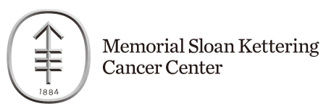

[![Python](https://img.shields.io/pypi/pyversions/tensorflow.svg?style=plastic)](https://badge.fury.io/py/tensorflow)

In [1]:
#----------------------------------------------------------------------------------
# THIS PROGRAM TAKES A TEST CSV FILE WITH ABSOLUTE NIFTI IMAGE PATH AND PASS
# THROUGH TRAINED MODELS TO GENERATE A PROBABILITY OUTPUT FILE AND ROC PLOT
#----------------------------------------------------------------------------------
""" Note: Here, Input file is substracted T1_Fat_Sat Nifti file """
"""       a) User need to convert nifti image of T1_Fat_Sat (i.e., T1_post1-T1_pre) prior to implementing the code 
          b) The program works well for tensorflow version 2.5.3 since model uses lamda layer which is depricated 
             in recent versions of tensorflow
          c) Download the trained weight from https://drive.google.com/drive/folders/1Xdjpgld-xnEfAy1f1iTcq6BnfnibKODu?usp=sharing
             and copy weights from download folder to output folder """
#
"""IMPORT ESSENTIAL LIBRARIES"""
import os, logging
logging.disable(logging.WARNING)  # Hides logging warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import sys
import time
import numpy             as np
import pandas            as pd
import nibabel           as nib
import matplotlib.pyplot as plt
#
"""SUPPORTING IN-BUILT LIBRARIES"""
from os.path            import dirname, realpath
from collections        import Counter
import tensorflow       as tf
from sklearn.metrics    import confusion_matrix, roc_curve
from tqdm               import tqdm
from scipy              import stats
#

In [2]:
#
print(tf.__version__)

2.5.3


In [ ]:
""" Input hyperparameters """
hp = {}
hp["default_path"]   = dirname(dirname(realpath("inference.ipynb")))
hp["csv_path"]       = os.path.join(hp["default_path"], 'input') # CSV path
hp["csv_name"]       = "test_dataset"                            # CSV filename
hp["model_path"]     = os.path.join(hp["default_path"], 'output') # Model path
hp["saved_model"]    = ["unet_weight.h5", "vgg16_weight_fold1.h5", "vgg16_weight_fold2.h5", 
                        "vgg16_weight_fold3.h5", "vgg16_weight_fold4.h5", "vgg16_weight_fold5.h5"]
hp["test_threshold"] = 0.33                                      # default threshold
#

In [ ]:
""" Load custom functions """
sys.path.append(hp["default_path"])
from support_function import custom_model_unet, predict, compute_auc
#

In [ ]:
#######
""" STEP - 1: SOME FUNCTIONS CALLED IN MAIN """
######
""" (A) CSV Reading function """
def read_csv(dirpath,filename):
    #
    """READS INTO A DATAFRAME"""
    df = pd.read_csv(os.path.join(dirpath, filename + '.csv'))
    img_paths = df.File_path.tolist()             # File path
    img_labels = df.Patho.tolist()                # Pathology label
    img_mrn = df.MRN.tolist()                     # MRNS
    img_acc = df.Accession.tolist()               # Accession
    #
    return img_mrn, img_acc, img_paths, img_labels
#
""" (B) Function to convert T1_sub NIFTI image (i.e., T1_post1-T1_pre) to mip and three sub-mip """
def create_submip4rmnifti(img_path):
    image_org = nib.load(img_path).get_fdata()
    length = int(image_org.shape[2]/3)
    mip = np.amax(image_org[:, :, 0:image_org.shape[2]],2)
    submip1=np.amax(image_org[:, :, 0:length],2)
    submip2=np.amax(image_org[:, :, length:(2*length)],2)
    submip3=np.amax(image_org[:, :, (2*length):image_org.shape[2]],2)
    return mip, submip1, submip2, submip3
#
""" (C) Pre-trained unet loading function """
def load_unet(dirpath,filename):
    #
    pathunet=os.path.join(dirpath, filename)
    Unet_image_size    = 224
    Unet_image_channel = 1
    model=custom_model_unet.unet(Unet_image_size, Unet_image_channel)
    model.load_weights(pathunet)
    #
    return model
#
""" (D) Pre-trained classification model loading function """
def load_classifier(dirpath,filename):
    #
    model=tf.keras.models.load_model(os.path.join(dirpath, filename))
    #
    return model
#

In [ ]:
#
global_start = time.time()    # Records the begining of the program
#

In [ ]:
#######
""" STEP - 2: PREDICTION """
######
#
if __name__ == "__main__":
    #
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)
    #
    """ Checks availability of gpu """
    gpu_available = tf.test.is_gpu_available()
    if gpu_available:
        """ Set gpu device """
        gpus = tf.config.experimental.list_physical_devices('GPU')
        tf.config.set_visible_devices(gpus[0], 'GPU')
        #
    #
    """ load models (unet + fold1-5) """
    model_unet  = load_unet(hp["model_path"],hp["saved_model"][0])
    model_fold1 = load_classifier(hp["model_path"],hp["saved_model"][1])
    model_fold2 = load_classifier(hp["model_path"],hp["saved_model"][2])
    model_fold3 = load_classifier(hp["model_path"],hp["saved_model"][3])
    model_fold4 = load_classifier(hp["model_path"],hp["saved_model"][4])
    model_fold5 = load_classifier(hp["model_path"],hp["saved_model"][5])
    #
    """ load the CSV data with image path """
    img_mrns, img_accs, img_paths, img_labels = read_csv(hp["csv_path"],hp["csv_name"])
    #
    """ Prediction for each accession """
    data=[]
    for idx in tqdm(range(len(img_paths))):
        #
        mip, submip1, submip2, submip3 = create_submip4rmnifti(img_paths[idx]) # loads images
        #
        """ probability of mip images """
        pred_r_fold1, pred_l_fold1 = predict.probability(mip, model_unet, model_fold1) # fold1
        pred_r_fold2, pred_l_fold2 = predict.probability(mip, model_unet, model_fold2) # fold2
        pred_r_fold3, pred_l_fold3 = predict.probability(mip, model_unet, model_fold3) # fold3
        pred_r_fold4, pred_l_fold4 = predict.probability(mip, model_unet, model_fold4) # fold4
        pred_r_fold5, pred_l_fold5 = predict.probability(mip, model_unet, model_fold5) # fold5
        """ average of score for mip images """
        prediction_right_neg=(pred_r_fold1[0][0]+pred_r_fold2[0][0]+pred_r_fold3[0][0]+pred_r_fold4[0][0]+pred_r_fold5[0][0])/5
        prediction_right_pos=(pred_r_fold1[0][1]+pred_r_fold2[0][1]+pred_r_fold3[0][1]+pred_r_fold4[0][1]+pred_r_fold5[0][1])/5
        prediction_left_neg=(pred_l_fold1[0][0]+pred_l_fold2[0][0]+pred_l_fold3[0][0]+pred_l_fold4[0][0]+pred_l_fold5[0][0])/5
        prediction_left_pos=(pred_l_fold1[0][1]+pred_l_fold2[0][1]+pred_l_fold3[0][1]+pred_l_fold4[0][1]+pred_l_fold5[0][1])/5
        #
        """ probability of fold 1 in case of 3 sub-mip images """
        pred_r_1of3_fold1, pred_l_1of3_fold1 = predict.probability(submip1, model_unet, model_fold1)
        pred_r_2of3_fold1, pred_l_2of3_fold1 = predict.probability(submip2, model_unet, model_fold1)
        pred_r_3of3_fold1, pred_l_3of3_fold1 = predict.probability(submip3, model_unet, model_fold1)
        #
        """ probability of fold 2 in case of 3 sub-mip images """
        pred_r_1of3_fold2, pred_l_1of3_fold2 = predict.probability(submip1, model_unet, model_fold2)
        pred_r_2of3_fold2, pred_l_2of3_fold2 = predict.probability(submip2, model_unet, model_fold2)
        pred_r_3of3_fold2, pred_l_3of3_fold2 = predict.probability(submip3, model_unet, model_fold2)
        #
        """ probability of fold 3 in case of 3 sub-mip images """
        pred_r_1of3_fold3, pred_l_1of3_fold3 = predict.probability(submip1, model_unet, model_fold3)
        pred_r_2of3_fold3, pred_l_2of3_fold3 = predict.probability(submip2, model_unet, model_fold3)
        pred_r_3of3_fold3, pred_l_3of3_fold3 = predict.probability(submip3, model_unet, model_fold3)
        #
        """ probability of fold 4 in case of 3 sub-mip images """
        pred_r_1of3_fold4, pred_l_1of3_fold4 = predict.probability(submip1, model_unet, model_fold4)
        pred_r_2of3_fold4, pred_l_2of3_fold4 = predict.probability(submip2, model_unet, model_fold4)
        pred_r_3of3_fold4, pred_l_3of3_fold4 = predict.probability(submip3, model_unet, model_fold4)
        #
        """ probability of fold 5 in case of 3 sub-mip images """
        pred_r_1of3_fold5, pred_l_1of3_fold5 = predict.probability(submip1, model_unet, model_fold5)
        pred_r_2of3_fold5, pred_l_2of3_fold5 = predict.probability(submip2, model_unet, model_fold5)
        pred_r_3of3_fold5, pred_l_3of3_fold5 = predict.probability(submip3, model_unet, model_fold5)
        #
        """ average of score for submips """
        prediction_right_1of3_neg=(pred_r_1of3_fold1[0][0]+pred_r_1of3_fold2[0][0]+pred_r_1of3_fold3[0][0]+pred_r_1of3_fold4[0][0]+pred_r_1of3_fold5[0][0])/5
        prediction_right_1of3_pos=(pred_r_1of3_fold1[0][1]+pred_r_1of3_fold2[0][1]+pred_r_1of3_fold3[0][1]+pred_r_1of3_fold4[0][1]+pred_r_1of3_fold5[0][1])/5
        prediction_left_1of3_neg=(pred_l_1of3_fold1[0][0]+pred_l_1of3_fold2[0][0]+pred_l_1of3_fold3[0][0]+pred_l_1of3_fold4[0][0]+pred_l_1of3_fold5[0][0])/5
        prediction_left_1of3_pos=(pred_l_1of3_fold1[0][1]+pred_l_1of3_fold2[0][1]+pred_l_1of3_fold3[0][1]+pred_l_1of3_fold4[0][1]+pred_l_1of3_fold5[0][1])/5
        #
        prediction_right_2of3_neg=(pred_r_2of3_fold1[0][0]+pred_r_2of3_fold2[0][0]+pred_r_2of3_fold3[0][0]+pred_r_2of3_fold4[0][0]+pred_r_2of3_fold5[0][0])/5
        prediction_right_2of3_pos=(pred_r_2of3_fold1[0][1]+pred_r_2of3_fold2[0][1]+pred_r_2of3_fold3[0][1]+pred_r_2of3_fold4[0][1]+pred_r_2of3_fold5[0][1])/5
        prediction_left_2of3_neg=(pred_l_2of3_fold1[0][0]+pred_l_2of3_fold2[0][0]+pred_l_2of3_fold3[0][0]+pred_l_2of3_fold4[0][0]+pred_l_2of3_fold5[0][0])/5
        prediction_left_2of3_pos=(pred_l_2of3_fold1[0][1]+pred_l_2of3_fold2[0][1]+pred_l_2of3_fold3[0][1]+pred_l_2of3_fold4[0][1]+pred_l_2of3_fold5[0][1])/5
        #
        prediction_right_3of3_neg=(pred_r_3of3_fold1[0][0]+pred_r_3of3_fold2[0][0]+pred_r_3of3_fold3[0][0]+pred_r_3of3_fold4[0][0]+pred_r_3of3_fold5[0][0])/5
        prediction_right_3of3_pos=(pred_r_3of3_fold1[0][1]+pred_r_3of3_fold2[0][1]+pred_r_3of3_fold3[0][1]+pred_r_3of3_fold4[0][1]+pred_r_3of3_fold5[0][1])/5
        prediction_left_3of3_neg=(pred_l_3of3_fold1[0][0]+pred_l_3of3_fold2[0][0]+pred_l_3of3_fold3[0][0]+pred_l_3of3_fold4[0][0]+pred_l_3of3_fold5[0][0])/5
        prediction_left_3of3_pos=(pred_l_3of3_fold1[0][1]+pred_l_3of3_fold2[0][1]+pred_l_3of3_fold3[0][1]+pred_l_3of3_fold4[0][1]+pred_l_3of3_fold5[0][1])/5
        #
        ensemble_probability = max(prediction_right_pos, prediction_left_pos, prediction_right_1of3_pos, 
                                  prediction_right_2of3_pos, prediction_right_3of3_pos, prediction_left_1of3_pos,
                                  prediction_left_2of3_pos, prediction_left_3of3_pos)
        """ Class prediction """
        if (prediction_right_pos<hp["test_threshold"]) and (prediction_left_pos<hp["test_threshold"]) and (prediction_right_1of3_pos<hp["test_threshold"]) and (prediction_right_2of3_pos<hp["test_threshold"]) and (prediction_right_3of3_pos<hp["test_threshold"]) and (prediction_left_1of3_pos<hp["test_threshold"]) and (prediction_left_2of3_pos<hp["test_threshold"]) and (prediction_left_3of3_pos<hp["test_threshold"]):
            pred_labels=0
        else:
            pred_labels=1
        #
        """ Store data """
        data.append((img_mrns[idx], img_accs[idx], 
                     img_paths[idx], prediction_right_pos, prediction_right_1of3_pos, prediction_right_2of3_pos, prediction_right_3of3_pos,
                     prediction_left_pos, prediction_left_1of3_pos, prediction_left_2of3_pos, prediction_left_3of3_pos, ensemble_probability,
                     img_labels[idx], pred_labels))
        #
    #
    """ header names """
    col=['MRN', 'Accession', 'File_path', 'Prob_right_mip',
         'Prob_right13_submip', 'Prob_right23_submip', 'Prob_right33_submip', 'Prob_left_mip', 
         'Prob_left13_submip', 'Prob_left23_submip', 'Prob_left33_submip','Ensemble_probability', 
         'Ground_labels', 'Predicted_labels']
    #
    output_table = pd.DataFrame(data, columns=col)
    output_table.to_csv(os.path.join(hp["model_path"], 'probability.csv'), index=False)    # SAVES THE OUTPUT TABLE
    #
#

In [ ]:
#######
""" STEP - 3: OUTPUT PERFORMANCE """
######
""" Predict sensitivity and specificity for model threshold locked at hp["test_threshold"] = 0.33 """
df = pd.read_csv(os.path.join(hp["model_path"], 'probability.csv'))
true_labels = df.Ground_labels.tolist()
pred_labels = df.Predicted_labels.tolist()
Probability = df.Ensemble_probability.tolist()
#
counter_predict  = Counter(pred_labels)
counter_ground=Counter(true_labels)
positive_labels = counter_predict[1]
negative_labels = counter_predict[0]
GTP = counter_ground[1]
GTN = counter_ground[0]
#
if (GTP!=0) and (GTN!=0):
    TN, FP, FN, TP = confusion_matrix(true_labels, pred_labels).ravel()    # DETERMINE THE CONFUSION MATRIX
    Sensitivity = TP/(TP+FN),              # RECALL OR SENSITIVITY (POSITIVE CASES CORRECTLY IDENTIFIED AS POSITIVE)
    Specificity = TN/(TN+FP),              # SPECIFICITY (NEGATIVE CASES CORRECTLY IDENTIFIED AS NEGATIVE)
    print("Performance for model threshold:", hp["test_threshold"])
    print('(a) Completely Normal exams triaged by model:', negative_labels, "\n(b) Sensitivity:", (100*Sensitivity),"%" " \n(c) Specificity:", (100*Specificity),"%")
    #
else:
    print("Performance for model threshold:", hp["test_threshold"])
    print("Completely Normal exams triaged by model:", negative_labels)
#

In [ ]:
#######
""" STEP - 4: PLOT ROC """
######
""" Predict ROC Curve for model threshold varied from 0.00 to 1.00 """
if (GTP!=0) and (GTN!=0) and (GTP>=10) and (GTN>=10):
    # Predicts the false positive rate and true positive rate
    fpr, tpr, _ = roc_curve(np.array(true_labels), np.array(Probability), pos_label=1)
    # Predicts the auc with 95% CI
    alpha = .95
    auc, auc_cov = compute_auc.delong_roc_variance(np.array(true_labels), np.array(Probability))
    auc_std = np.sqrt(auc_cov)
    lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)
    ci = stats.norm.ppf(lower_upper_q, loc=auc, scale=auc_std)
    ci[ci > 1] = 1
    # Plot the ROC curve
    plt.figure(figsize=(5, 5))
    plt.plot(fpr,tpr,linestyle='-',color = 'black');
    plt.legend(["{} {:.3f} {} {} {:.4f}, {:.4f} {}".format('AUC:', auc, '\n95% CI:', '[', ci[0], ci[1], ']')], loc='best')
    plt.title('ROC Curve', size = 12);
    plt.xlabel('False Positive Rate', size = 12);
    plt.ylabel('True Positive Rate', size = 12);
    plt.savefig(os.path.join(hp["model_path"], 'roc.png'))
#

In [ ]:
global_end = time.time()     # End of program
#
print(f"Spent time: {(global_end - global_start)/60} min")
#